In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import torch

## Training accuracies

In [24]:
mis_acc = pd.read_csv('/home/gridsan/arunas/broca/llama/experiments/old-prompt/acc.csv')
mis_new_acc = pd.read_csv('/home/gridsan/arunas/broca/llama/experiments/new-prompt-prologue-random-seed/acc.csv')

In [25]:
merged_df = pd.merge(mis_acc, mis_new_acc, on='type', how='outer')

In [26]:
merged_df = merged_df.rename(columns={'accuracy_x': 'llama', 'accuracy_y': 'llama (new prologue)'})
merged_df.index=merged_df['type']

<Figure size 1600x2400 with 0 Axes>

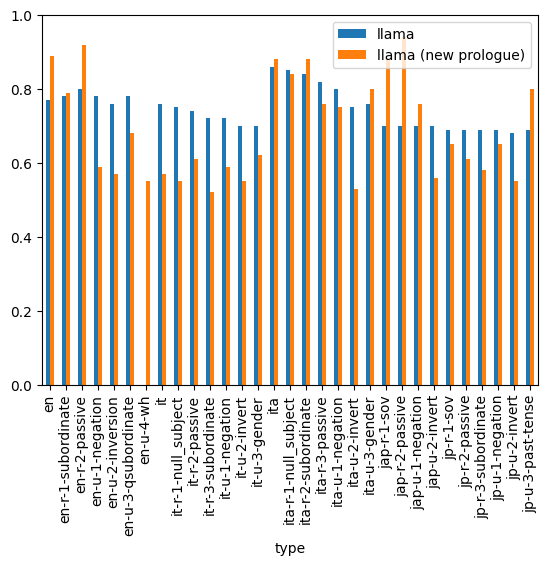

In [34]:
plt.figure(figsize=(20, 30), dpi=80)
ax = merged_df.sort_index().plot.bar(rot=90)
ax.set_ylim(0, 1)
fig = ax.get_figure()
# fig.tight_layout()
# ax.get_legend().remove()
# fig.savefig('/home/gridsan/arunas/broca/mistral/experiments/model-accuracies.png')



## Top 1% neurons confusion matrix

In [ ]:
def conf_matrix(model, component, topK):
    og = pd.read_csv('/home/gridsan/arunas/broca/data-gen/ngs.csv')
    columns = [col for col in sorted(og.columns) if not 'ng-' in col]
    component = pd.DataFrame(columns=np.arange(0,6553), index=sorted(columns))
    for col in sorted(columns):
        with open(f'/home/gridsan/arunas/broca/{model}/atp/patches/{component}/all-neurons/{col}.pkl', 'rb') as f:
            attn_cache = pickle.load(f)
            attn_cache = attn_cache.cpu()
            flattened_effects_cache = attn_cache.view(-1)
            top_neurons = flattened_effects_cache.topk(k=int(topK * flattened_effects_cache.shape[-1]))
            two_d_indices = torch.cat((((top_neurons[1] // attn_cache.shape[1]).unsqueeze(1)), ((top_neurons[1] % attn_cache.shape[1]).unsqueeze(1))), dim=1)            
            df = pd.DataFrame(two_d_indices, columns=['layer', 'neuron'])
            for idx, row in df.iterrows():
                component.loc[(component.index==col),idx] = ",".join([str(row['layer']), str(row['neuron'])])
    
    attn_overlap = pd.DataFrame(columns=sorted(component.columns), index=sorted(component.columns))
    for col in sorted(component.columns):
        for col1 in sorted(component.columns):
            if (len(component[component[col] == 1]) > 0):
                attn_overlap.loc[(attn_overlap.index == col), col1] = len(component[(component[col] == component[col1])])/(len(component[col]) + len(component[col1]) - len(component[(component[col] == component[col1])]))
        attn_overlap[col] = attn_overlap[col].astype(float)
    plt.imshow(attn_overlap, cmap='binary', aspect='auto', interpolation='nearest')
    plt.xticks(range(len(sorted(attn_overlap.columns))), sorted(attn_overlap.columns))
    plt.yticks(range(len(sorted(attn_overlap.index))), sorted(attn_overlap.index))
    plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
    plt.yticks(fontsize=8)  # Set y-axis tick label font size
    plt.colorbar()
    plt.title(f'{model.title()} {component.title()}')
    plt.tight_layout()
    # plt.savefig(f'/home/gridsan/arunas/broca/{model}/atp/patches/{component}/all-neurons-new-prompt-prologue-random-seed/overlap-{topK}.png')
    plt.show()

In [ ]:
conf_matrix('llama', 'attn')
conf_matrix('mistral', 'attn')
conf_matrix('llama', 'mlp')
conf_matrix('mistral', 'mlp')

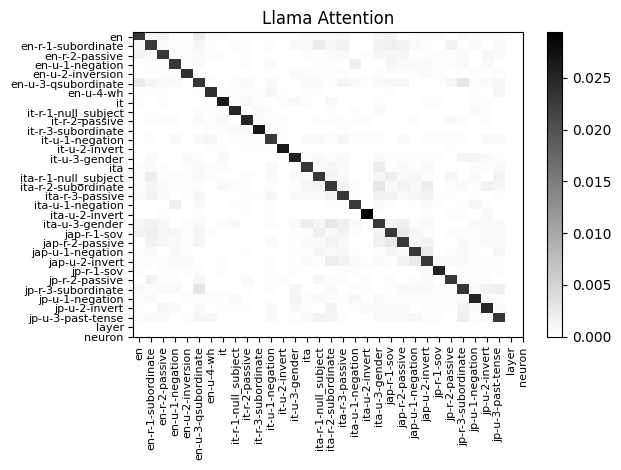

In [18]:
og = pd.read_csv('/home/gridsan/arunas/broca/data-gen/ngs.csv')
columns = [col for col in sorted(og.columns) if not 'ng-' in col]
lang_dim = len(columns)
layer_dim = 31 #num_layers in Llama
neuron_dim = 65 #0.01 * flattened_effects_cache.shape[-1] -- i.e num neruons considered
layers = torch.empty((lang_dim, neuron_dim))
neurons = torch.empty((lang_dim, neuron_dim))
for col_idx, col in enumerate(sorted(columns)):
    # print(col)
    with open(f'/home/gridsan/arunas/broca/llama/atp/patches/attn/all-neurons-new-prompt-prologue-random-seed/{col}.pkl', 'rb') as f:
        attn_cache = pickle.load(f)
        attn_cache = attn_cache.cpu()
        flattened_effects_cache = attn_cache.view(-1)
        top_neurons = flattened_effects_cache.topk(k=int(0.0001 * flattened_effects_cache.shape[-1]))
        two_d_indices = torch.cat((((top_neurons[1] // attn_cache.shape[1]).unsqueeze(1)), ((top_neurons[1] % attn_cache.shape[1]).unsqueeze(1))), dim=1)    
        layers[col_idx, :] = two_d_indices[:, 0]
        neurons[col_idx, :] = two_d_indices[:, 1]

# layers[0]
overlap_tensor = torch.zeros(lang_dim, lang_dim)
for i in range(lang_dim):
    for j in range(i, lang_dim):
        # print((layers[i].view(-1) == layer_dim).sum().item(), layers[i].view(-1))
        # if ((layers[i].view(-1) == layer_dim).sum().item() > 0 and (layers[j].view(-1) == layer_dim).sum().item()):
        overlap_percentage = ((((layers[i].view(-1) == layers[j].view(-1)) & (neurons[i].view(-1) == neurons[j].view(-1)))).sum().item())/(layers[i].view(-1)).sum().item()
        overlap_tensor[i, j] = overlap_percentage
        overlap_tensor[j, i] = overlap_percentage  # Due to symmetry

overlap = pd.DataFrame(overlap_tensor, columns=sorted(columns), index=sorted(columns))
plt.imshow(overlap, cmap='binary', aspect='auto', interpolation='nearest')
plt.xticks(range(len(sorted(attn_overlap.columns))), sorted(attn_overlap.columns))
plt.yticks(range(len(sorted(attn_overlap.index))), sorted(attn_overlap.index))
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
plt.colorbar()
plt.title('Llama Attention')
plt.tight_layout()
# plt.savefig('/home/gridsan/arunas/broca/llama/atp/patches/attn/all-neurons-new-prompt-prologue-random-seed/overlap-1-percent.png')
plt.show()

In [142]:
# columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
# filtered_columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it-r-2-passive', 'it-r-3-subordinate', 'jp-u-3-past-tense']
og = pd.read_csv('/home/gridsan/arunas/broca/data-gen/ngs.csv')
columns = [col for col in og.columns if not 'ng-' in col]
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
for col in sorted(columns):
    with open(f'/home/gridsan/arunas/broca/mistral/atp/patches/mlp/all-neurons-new-prompt-prologue-random-seed/{col}.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, columns=['layer', 'neuron'])
        for idx, row in df.iterrows():
            mlp.loc[(mlp['neuron'] == row['neuron']) & (mlp['layer'] == row['layer']), col] = 1
# mlp = mlp[~(mlp[columns] == 0).all(axis=1)]
mlp = mlp[sorted(columns)]

mlp_overlap = pd.DataFrame(columns=sorted(mlp.columns), index=sorted(mlp.columns))

for col in sorted(mlp.columns):
    for col1 in sorted(mlp.columns):
        mlp_overlap.loc[(mlp_overlap.index == col), col1] = float(( (mlp[col] == mlp[col1]) & (mlp[col] != 0) ).sum()/len(mlp))
    mlp_overlap[col] = mlp_overlap[col].astype(float)

plt.imshow(mlp_overlap, cmap='binary', aspect='auto', interpolation='nearest')
plt.xticks(range(len(mlp_overlap.columns)), sorted(mlp_overlap.columns))
plt.yticks(range(len(mlp_overlap.index)), sorted(mlp_overlap.index))
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
# plt.grid(True)
plt.colorbar()
plt.title('Confusion Matrix')
plt.tight_layout()
# plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/mlp-overlap.png')
plt.show()

ValueError: Shape of passed values is (32, 4096), indices imply (32, 2)

## Distribution of activations of all neurons

In [71]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
layer31 = []
layer0 = []
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/{col}-all-neurons.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, index=range(32), columns=range(4096))
        layer31.append(df[df.index==31].values[0,:])
        layer0.append(df[df.index==0].values[0,:])

/state/partition1/slurm_tmp/25169865.0.0/ipykernel_1432574/3215867080.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(columns, rotation=90)


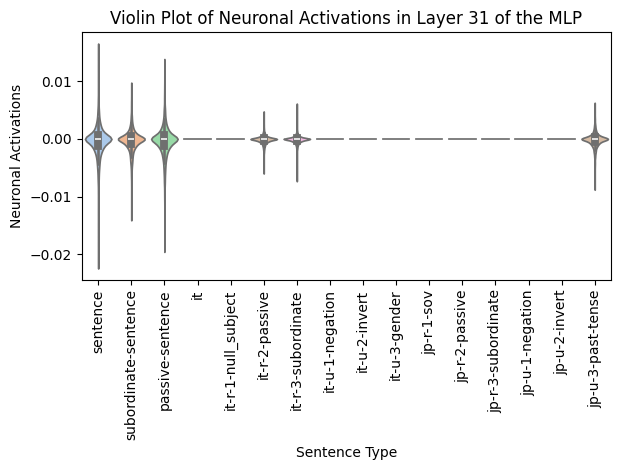

In [72]:


ax = sns.violinplot(data=layer31,  palette="pastel")
ax.set_xticklabels(columns, rotation=90)
plt.xlabel('Sentence Type')
plt.ylabel('Neuronal Activations')
plt.title('Violin Plot of Neuronal Activations in Layer 31 of the MLP')
plt.tight_layout()
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/mlp-neuron-dists.png')
plt.show()

In [73]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
attn = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
attn['neuron'] = np.arange(0,4096)
attn[columns] = 0
attn['layer'] = 31
layer31 = []
layer0 = []
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/attn/{col}-all-neurons.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, index=range(32), columns=range(4096))
        layer31.append(df[df.index==31].values[0,:])
        layer0.append(df[df.index==0].values[0,:])

/state/partition1/slurm_tmp/25169865.0.0/ipykernel_1432574/2836353760.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(columns, rotation=90)


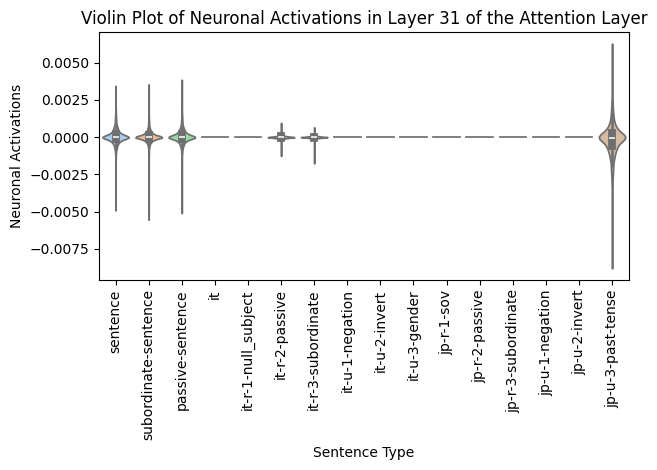

In [74]:


ax = sns.violinplot(data=layer31,  palette="pastel")
ax.set_xticklabels(columns, rotation=90)
plt.xlabel('Sentence Type')
plt.ylabel('Neuronal Activations')
plt.title('Violin Plot of Neuronal Activations in Layer 31 of the Attention Layer')
plt.tight_layout()
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/attn/attn-neuron-dists.png')
plt.show()

## All neurons confusion matrix

In [75]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
filtered_columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it-r-2-passive', 'it-r-3-subordinate', 'jp-u-3-past-tense']
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/{col}-all-neurons.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, columns=['layer', 'neuron'])
        for idx, row in df.iterrows():
            mlp.loc[(mlp['neuron'] == row['neuron']) & (mlp['layer'] == row['layer']), col] = 1
# mlp = mlp[~(mlp[columns] == 0).all(axis=1)]
mlp = mlp[columns]

mlp_overlap = pd.DataFrame(columns=mlp.columns, index=mlp.columns)

for col in mlp.columns:
    for col1 in mlp.columns:
        mlp_overlap.loc[(mlp_overlap.index == col), col1] = float(( (mlp[col] == mlp[col1]) & (mlp[col] != 0) ).sum()/len(mlp))
    mlp_overlap[col] = mlp_overlap[col].astype(float)

plt.imshow(mlp_overlap, cmap='binary', aspect='auto', interpolation='nearest')
plt.xticks(range(len(mlp_overlap.columns)), mlp_overlap.columns)
plt.yticks(range(len(mlp_overlap.index)), mlp_overlap.index)
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
# plt.grid(True)
plt.colorbar()
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/mlp-overlap-all.png')
plt.show()

ValueError: Shape of passed values is (32, 4096), indices imply (32, 2)